# 転移学習

### いつもの設定

In [1]:
from type_hint import *
from import_str import importstr
from log_conf import logging
log = logging.getLogger('nb')

# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

# running everything app
def run(app, *argv):
    argv = list(argv)
    log.info('Running: {}({!r}).main()'.format(app, argv))
    print("*app.rsplit('.', 1) : ", *app.rsplit('.', 1))

    app_cls = importstr(*app.rsplit('.', 1)) # __import__を実行
    app_cls(argv).main()

    log.info("Finished: {}.({!r}).main()".format(app, argv))

module_parent_dir /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/..
module_parent_dir /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/..
module_parent_dir /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/..


### 画像前処理動作を確認

2023-06-23 01:17:50,336 INFO     pid:19878 nb:013:run Running: TransferLearing.preprocess.PreprocessImageApp([]).main()


*app.rsplit('.', 1) :  TransferLearing.preprocess PreprocessImageApp
module_parent_dir /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/..


2023-06-23 01:17:52,369 INFO     pid:19878 TransferLearing.preprocess:086:main Starting PreprocessImageApp, Namespace()


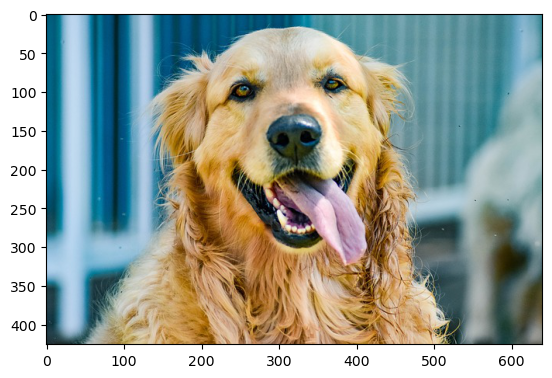

img_transformed_transposed : [[[ 0.5193082   1.2205883   1.9428324 ]
  [ 0.21106265  1.0105042   1.7859696 ]
  [-0.35405433  0.6778712   1.454815  ]
  ...
  [-0.09718303  0.9754903   1.6988237 ]
  [ 0.05693974  1.0630252   1.7511113 ]
  [ 0.17681314  1.1155462   1.7685405 ]]

 [[ 0.5193082   1.2380953   1.9428324 ]
  [ 0.2281874   1.0280112   1.8033988 ]
  [-0.37117907  0.6778712   1.454815  ]
  ...
  [-0.09718303  0.9929972   1.6988237 ]
  [ 0.05693974  1.0630252   1.7511113 ]
  [ 0.1939379   1.1330533   1.7859696 ]]

 [[ 0.50218344  1.2380953   1.9428324 ]
  [ 0.1939379   1.0280112   1.7859696 ]
  [-0.37117907  0.6778712   1.454815  ]
  ...
  [-0.02868402  1.0630252   1.7685405 ]
  [ 0.14256364  1.1505603   1.8556864 ]
  [ 0.1939379   1.1330533   1.8033988 ]]

 ...

 [[ 1.5296686   1.2906163   0.8622224 ]
  [ 1.5296686   1.3606442   0.9319392 ]
  [ 1.6495419   1.5357143   1.2979523 ]
  ...
  [-1.1246684  -0.792717   -0.68897593]
  [-1.1760426  -0.862745   -0.7586928 ]
  [-1.141793   

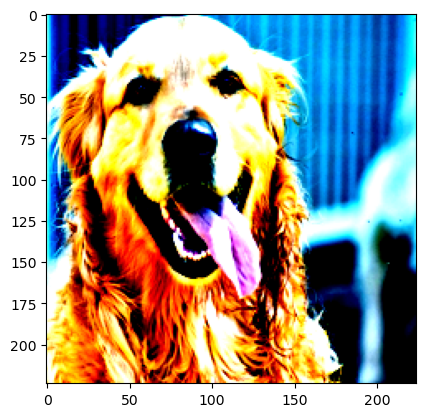

2023-06-23 01:17:53,006 INFO     pid:19878 nb:019:run Finished: TransferLearing.preprocess.PreprocessImageApp.([]).main()


In [2]:
run('TransferLearing.preprocess.PreprocessImageApp')

### 転移先のアリとハチを分類するためのデータセット

In [3]:
run('TransferLearing.ant_bee_dataset.HymenopteraDatasetApp')

2023-06-23 01:17:53,029 INFO     pid:19878 nb:013:run Running: TransferLearing.ant_bee_dataset.HymenopteraDatasetApp([]).main()
2023-06-23 01:17:53,048 INFO     pid:19878 TransferLearing.ant_bee_dataset:137:main Starting HymenopteraDatasetApp, Namespace()
2023-06-23 01:17:53,065 INFO     pid:19878 nb:019:run Finished: TransferLearing.ant_bee_dataset.HymenopteraDatasetApp.([]).main()


*app.rsplit('.', 1) :  TransferLearing.ant_bee_dataset HymenopteraDatasetApp
module_parent_dir /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/..
/Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/**/*.jpg
0: /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/bees/2638074627_6b3ae746a0.jpg
1: /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/bees/507288830_f46e8d4cb2.jpg
2: /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/bees/2405441001_b06c36fa72.jpg
3: /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/bees/2962405283_22718d9617.jpg
4: /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/bees/446296270_d9e8b93ecf.jpg
5: 

### 転移学習(FineTune)による学習と検証

In [4]:
epochs = 2
batch_size = 32
run('TransferLearing.transfer_learning.TransferLearningApp', f"--batch-size={batch_size}", f"--epochs={epochs}")

2023-06-23 01:17:53,092 INFO     pid:19878 nb:013:run Running: TransferLearing.transfer_learning.TransferLearningApp(['--batch-size=32', '--epochs=2']).main()


*app.rsplit('.', 1) :  TransferLearing.transfer_learning TransferLearningApp
module_parent_dir /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/..
module_parent_dir /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/..


/Users/inoueshinichi/opt/anaconda3/envs/Py38WorkEnv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/inoueshinichi/opt/anaconda3/envs/Py38WorkEnv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2023-06-23 01:17:55,124 INFO     pid:19878 TransferLearing.transfer_learning:321:main Starting TransferLearningApp, Namespace(batch_size=32, epochs=2, finetune='', finetune_depth=1, num_workers=2, save_modeldir='models', tb_logdir='runs', tb_prefix='hymenoptera')
2023-06-23 01:17:55,125 INFO     pid:19

/Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/**/*.jpg
0: /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/bees/2638074627_6b3ae746a0.jpg
1: /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/bees/507288830_f46e8d4cb2.jpg
2: /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/bees/2405441001_b06c36fa72.jpg
3: /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/bees/2962405283_22718d9617.jpg
4: /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/bees/446296270_d9e8b93ecf.jpg
5: /Users/inoueshinichi/Desktop/MyGithub/Wiki_AI/TransferLearing/data/hymenoptera_data/archive/hymenoptera/train/bees/1092977343_cb42b38d62.jpg
6: /Users/inoueshin

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/inoueshinichi/opt/anaconda3/envs/Py38WorkEnv/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/inoueshinichi/opt/anaconda3/envs/Py38WorkEnv/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/Users/inoueshinichi/opt/anaconda3/envs/Py38WorkEnv/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/Users/inoueshinichi/opt/anaconda3/envs/Py38WorkEnv/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/Users/inoueshinichi/opt/anaconda3/envs/Py38WorkEnv/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/Users/inoueshinichi/opt/anaconda3/envs/Py38WorkEnv/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 150, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>
